<a href="https://colab.research.google.com/github/at19990/iTL_practice/blob/master/per_day_menu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

Saving building_3_per_day_2items_3.csv to building_3_per_day_2items_3 (2).csv


In [1]:
# read data
import pandas as pd

dataframe = pd.read_csv('building_3_per_day_2items_3.csv', encoding='shift-jis', header=0, engine='python',usecols=[2,4,5,6,7,8,9,10])

dataframe.head()

,70(ラーメン),ave_temp,max_temp,min_temp,precipitation,ave_humidity,dayOfWeek(月~日;0~6),休日判定
0,535,7.5,11.1,3.3,0.0,41,2,0
1,499,5.3,10.2,0.8,0.0,38,3,0
2,551,2.7,7.0,-1.6,0.0,36,4,0
3,313,2.7,7.3,-0.8,0.0,51,5,1
4,543,4.2,12.4,-1.1,0.0,53,0,0


In [0]:
import numpy
import matplotlib.pyplot as plt

In [3]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
dataset = dataframe.values
dataset = dataset.astype('float32')

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

220 95


In [29]:
# convert an array of values into a dataset matrix
# if you give look_back 3, a part of the array will be like this: Jan, Feb, Mar
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
        dataY.append(dataset[i + look_back, 0])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX.shape)
print(testX[0])
print(testY)

# reshape input to be [samples, time steps(number of variables), features] *convert time series into column
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

(92, 8, 2)
[[0.69305336 0.81906307]
 [0.5621118  0.5590062 ]
 [0.53239435 0.50985914]
 [0.5538462  0.5784615 ]
 [0.         0.        ]
 [0.62       0.68      ]
 [0.6        0.8       ]
 [0.         0.        ]]
[0.45557353 0.71082395 0.7592892  0.7043619  0.47819063 0.49919227
 0.450727   0.37641358 0.8077545  0.89176095 0.73021007 0.86429733
 0.50726986 0.74798065 0.75767374 0.806139   0.7318256  0.7027464
 0.5218094  0.7415186  0.7560582  0.82229406 0.76575124 0.67689824
 0.5347335  0.7592892  0.74474967 0.7883684  0.7609047  0.8287561
 0.39418417 0.79967695 0.7867529  0.815832   0.7560582  0.80452347
 0.3441034  0.78352183 0.7786753  0.78513736 0.73021007 0.9176091
 0.4717286  0.7318256  0.81744754 0.79483044 0.85621977 0.76575124
 0.5024233  0.67366725 0.8303716  0.7350566  0.904685   0.85621977
 0.79483044 0.41518578 0.898223   0.85460424 1.         0.56704366
 0.9305332  0.75282717 0.450727   0.9192246  0.53958    0.3117932
 0.81421655 0.717286   0.8336026  0.717286   0.80290794

In [31]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(testX.shape[1], look_back)))	#shape：変数数、遡る時間数
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=8000, batch_size=220, verbose=0)

In [32]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
pad_col = numpy.zeros(dataset.shape[1]-1)

# invert predictions
def pad_array(val):
    return numpy.array([numpy.insert(pad_col, 0, x) for x in val])
    
trainPredict = scaler.inverse_transform(pad_array(trainPredict))
trainY = scaler.inverse_transform(pad_array(trainY))
testPredict = scaler.inverse_transform(pad_array(testPredict))
testY = scaler.inverse_transform(pad_array(testY))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 36.13 RMSE
Test Score: 115.20 RMSE


[284.00000749 442.00001614 472.00000634 438.00001499 297.99999308
 311.00000605 280.99999741 235.00000259 502.00003344 554.00001153
 454.0000196  537.0000343  316.00003517 465.00001355 471.00003372
 501.00002392 455.00002911 437.00000548 325.00001009 461.00001239
 470.00002421 511.00000836 476.00000749 421.00000086 333.00001239
 472.00000634 463.00003142 490.00002998 473.00001585 515.00000951
 245.99999654 497.00002277 489.00002047 507.00000721 470.00002421
 500.00001441 214.99999683 487.00000144 484.0000098  488.00001095
 454.0000196  570.00001614 293.99999193 455.00002911 508.00001672
 494.00003113 532.00002364 476.00000749 313.00000663 419.00001874
 516.00001902 457.00001124 562.00001384 532.00002364 494.00003113
 258.99999106 558.00001268 531.00001412 620.99998472 353.00001816
 578.00001845 468.00000519 280.99999741 571.00002565 336.00000404
 194.99999106 506.00003459 446.00001729 518.00000115 446.00001729
 499.0000049  191.00000836 278.00000576 245.00000548 305.99999539
 247.99999

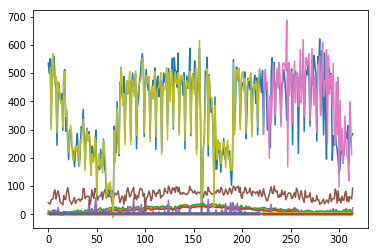

In [33]:
print(testY[:,0])
print(testPredict[:,0])
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()